# MMDS exercise sheet 3
### 2 - Random projections
#### Problem 2

In [1]:
import numpy as np
from scipy.spatial.distance import pdist
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import NMF
%matplotlib inline

In [2]:
N = 1000
d = 10000

In [3]:
# Generate N x d data matrix
data = np.random.uniform(low=-10, high=10, size=[N,d])

In [5]:
data.shape

(1000, 10000)

In [5]:
data[:3, :3]

array([[-5.33248212, -3.43236925, -5.24371821],
       [ 6.0787095 ,  8.68789803, -5.73160013],
       [ 1.31853156,  6.9294779 ,  1.4884506 ]])

In [6]:
# Compute pairwise distances. Omits duplicates (symmetry) and zeroes (diagonals)
distances = pdist(data)

In [7]:
distances.shape

(499500,)

In [8]:
distances[:5]

array([821.13281339, 822.00404058, 814.49210713, 819.67113749,
       816.58977307])

In [ ]:
all_maxs = []

dim_range = [2, 10,50, 100, 250, 500, 750, 1000]
for k in dim_range:
    maxs = []
    for _ in range(100): # repeat for 100 times

        # Create d x k projection matrix
        projection_matrix = np.random.randn(d, k)
        # Normalize the rows to norm 1
        projection_matrix = projection_matrix / np.linalg.norm(projection_matrix, axis=1)[:,None]

        # Project the data
        projected_data = np.dot(data, projection_matrix)
        # Compute distances in the low-dimensional space
        distances_projected = pdist(projected_data)

        # Relative deviations (factors)
        factors = distances_projected/distances

        # Store the maximum relative deviation factor
        maxs.append(np.abs(factors - 1).max())
        
    # Store the 100 max values
    all_maxs.append(maxs)    

In [12]:
distances_projected[:5]

array([816.14944319, 825.16705526, 806.70830495, 825.31167896,
       835.41928731])

In [13]:
distances[:5]

array([814.81068315, 814.16186138, 818.56438548, 822.51424212,
       815.5124413 ])

In [14]:
np.abs(distances_projected/distances - 1)[:5]

array([0.00164303, 0.01351721, 0.01448399, 0.00340108, 0.02441023])

In [15]:
np.abs(distances_projected/distances - 1).max()

0.11682437724606376

In [16]:
np.abs(distances_projected/distances - 1).mean()

0.017806723589544205

In [18]:
all_maxs = np.array(all_maxs)

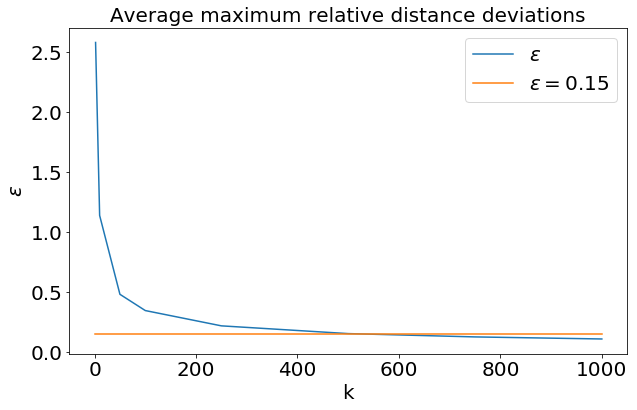

In [19]:
fig = plt.figure(figsize=(10,6))
plt.plot(dim_range, all_maxs.mean(1), label="$\epsilon$")
plt.plot((0,1000), (0.15, 0.15), label="$\epsilon=0.15$")
plt.title("Average maximum relative distance deviations", fontsize=20)
plt.xlabel("k", fontsize=20)
plt.ylabel("$\epsilon$", fontsize=20)
ax = plt.gca()
ax.tick_params(labelsize=20)
plt.legend(fontsize=20)
plt.show()

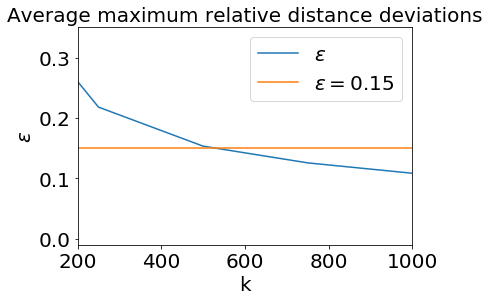

In [20]:
plt.plot(dim_range, all_maxs.mean(1), label="$\epsilon$")
plt.plot((0,1000), (0.15, 0.15), label="$\epsilon=0.15$")
plt.xlim((200, 1000))
plt.ylim((-0.01, 0.35))
plt.title("Average maximum relative distance deviations", fontsize=20)
plt.xlabel("k", fontsize=20)
plt.ylabel("$\epsilon$", fontsize=20)
ax = plt.gca()
ax.tick_params(labelsize=20)
plt.legend(fontsize=20)
plt.show()


### Exercise 3 - Matrix factorization
#### Problem 3

In [29]:
M = np.array([[4, 4, 0, 0, 3, 2, 2, 0],
     [1, 0, 0, 4, 0, 0, 1, 5],
     [0, 2, 3, 3, 0, 2, 1, 3],
     [1, 0, 1, 1, 2, 0, 4, 5],
     [4, 4, 4, 1, 1, 1, 0, 0],
     [0, 1, 1, 0, 4, 3, 0, 5]]).T.astype(np.float32)
print(M.shape)
M.astype("int")

(8, 6)


array([[4, 1, 0, 1, 4, 0],
       [4, 0, 2, 0, 4, 1],
       [0, 0, 3, 1, 4, 1],
       [0, 4, 3, 1, 1, 0],
       [3, 0, 0, 2, 1, 4],
       [2, 0, 2, 0, 1, 3],
       [2, 1, 1, 4, 0, 0],
       [0, 5, 3, 5, 0, 5]])

$M = U \cdot \Sigma \cdot V^T$

$Q = U \cdot \Sigma$

$P = V^T$

In [30]:
from scipy.sparse.linalg import svds

def init_Q_P(M, k, init="svd"):
    if init == 'svd':
        U, s, V = svds(M, k=k)
        print(U.shape, s.shape, V.shape)
        S = np.diag(s)
        Q = U.dot(S)
        P = V
    elif init == 'random':
        Q = np.random.random((M.shape[0], k))
        P = np.random.random((k, M.shape[1]))
    else:
        raise ValueError
    return P, Q

Least squares regression:  
$\mathbf{w}^* = \underset{\mathbf{w}}{\arg \min} \sum_{i=1}^{N}(y_i - \mathbf{x}_i^T\mathbf{w})^2 = \|\mathbf{y}-X\mathbf{w}\|_2^2  $


Solving least squares regression:   
$\mathbf{w}^* = (X^TX)^{-1}X^T\mathbf{y}$

In [31]:
def optimize(M, P, Q, verbose=True):
    loss = []
    
    for iter in range(10):
        loss.append(((M[M>0]-Q.dot(P)[M>0])**2).sum())
        if verbose:
            print('loss', loss[-1]) # print always the last element of the list
        # fix Q and update P
        for movie_idx in range(M.shape[1]): #iterate over whole movie dimension
            nnz_idx = np.argwhere(M[:, movie_idx]).flatten() #Find the indices of array elements that are non-zero, 
                                                             #store them in 1-D array.
            #solving OLS regresion
            res =np.linalg.inv(Q[nnz_idx].T.dot(Q[nnz_idx])).dot(Q[nnz_idx].T.dot(M[nnz_idx, movie_idx]))
            #update P
            P[:, movie_idx] = res

        # fix  P and update Q
        for user_idx in range(M.shape[0]):
            nnz_idx = np.argwhere(M[user_idx, :]).flatten()
            res =np.linalg.inv(P[:, nnz_idx].dot(P[:, nnz_idx].T)).dot(P[:, nnz_idx].dot(M[user_idx, nnz_idx]))
            Q[user_idx, :] = res
    return loss

In [32]:
P, Q = init_Q_P(M, k=3)

(8, 3) (3,) (3, 6)


loss 14.300928
loss 0.783092
loss 0.20321192
loss 0.069614336
loss 0.027482439
loss 0.012440527
loss 0.006530807
loss 0.004012868
loss 0.002858518
loss 0.0022869739


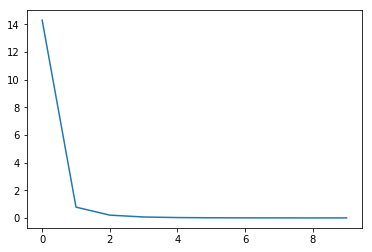

In [33]:
loss = optimize(M, P, Q)
plt.plot(loss)

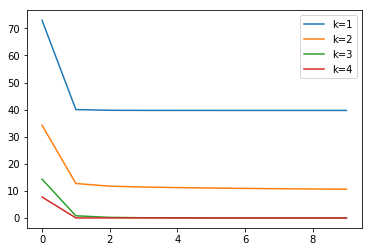

In [34]:
for k in range(1, 5):
    U, s, V = svds(M, k=k)
    S = np.diag(s)
    Q = U.dot(S)
    P = V
    loss = optimize(M, P, Q, False)
    plt.plot(loss, label='k={}'.format(k))
plt.legend()

In [35]:
U, s, V = svds(M, k=5)
S = np.diag(s)
Q = U.dot(S)
P = V
loss = optimize(M, P, Q, False)

LinAlgError: Singular matrix

In [36]:
P, Q = init_Q_P(M, k=3, init="random")
loss = optimize(M, P, Q, True)

loss 149.51336474397192
loss 10.145320934418816
loss 3.051966627133498
loss 1.600170377284293
loss 0.9496493211575245
loss 0.6411405990386831
loss 0.4853916778897326
loss 0.3849791915183579
loss 0.3113245538414094
loss 0.25394334773658556


#### Problem 4

In [37]:
# permutation that reveals the structure
# 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0
# 1 1 1 0 0 0 0 0 1 1 1 0 0 0 0
# 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0
# 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0
# 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0
# 0 0 1 1 1 0 0 0 1 1 1 0 0 0 0
# 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0
# 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
# 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
# 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
# 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
# 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
# 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
# 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
# 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [40]:
df = pd.read_csv('sheet_03_nmf.txt', delimiter=' ', header=None)
M = df.as_matrix()
M

array([[1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1],
       [1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int64)

In [41]:
for n_components in range(1, 6):
    nmf = NMF(n_components)
    nmf.fit(M)
    
    W = nmf.fit_transform(M);
    H = nmf.components_;
    
    print(n_components, nmf.reconstruction_err_)

1 3.378478610258
2 2.243284272946715
3 0.5519051195636271
4 0.0001954052139651126
5 0.00019540521396522073


In [42]:
nmf = NMF(3)
nmf.fit(M)

W = nmf.fit_transform(M);
H = nmf.components_;

In [43]:
w = np.round(W).astype("int")
w

array([[1, 0, 1],
       [1, 0, 0],
       [0, 0, 0],
       [1, 0, 0],
       [0, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 1, 1],
       [0, 0, 0],
       [0, 0, 0],
       [1, 1, 0],
       [0, 0, 0],
       [0, 0, 0]])

In [44]:
h = np.round(H).astype("int")
h

array([[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1]])

In [45]:
w.dot(h)

array([[1, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1],
       [1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

with NMF we need rank 4 approximation

with BMF we need only rank 3

### 4 - Regression and regularization
#### Problem 5

In [48]:
df = pd.read_csv('sheet_03_ozone.csv')

In [49]:
df.head()

,ozone,vh,wind,humidity,temp,ibh,dpg,ibt,vis,doy
0,3,5710,4,28,40,2693,-25,87,250,3
1,5,5700,3,37,45,590,-24,128,100,4
2,5,5760,3,51,54,1450,25,139,60,5
3,6,5720,4,69,35,1568,15,121,60,6
4,4,5790,6,19,45,2631,-33,123,100,7


In [50]:
data = df.as_matrix().astype(np.float32)
X, y = data[:, 1:], data[:, 0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.90, random_state=798)

Least squares regression:  
$\mathbf{w}^* = \underset{\mathbf{w}}{\arg \min} \sum_{i=1}^{N}(y_i - \mathbf{x}_i^T\mathbf{w})^2 = \|\mathbf{y}-X\mathbf{w}\|_2^2  $

Lasso regression:  
$\mathbf{w}^* = \underset{\mathbf{w}}{\arg \min} \|\mathbf{y}-X\mathbf{w}\|_2^2 + \lambda \|\mathbf{w}\|_1  $

Ridge regression:  
$\mathbf{w}^* = \underset{\mathbf{w}}{\arg \min} \|\mathbf{y}-X\mathbf{w}\|_2^2 + \lambda \|\mathbf{w}\|_2^2  $

In [51]:
linear = LinearRegression()
linear.fit(X_train, y_train)


y_train_p = linear.predict(X_train)
y_test_p = linear.predict(X_test)

Calculating the loss, sum of squared errors (SSE), on the train and test data

In [52]:
SSE = lambda y, y_p: ((y-y_p)**2).sum()

In [53]:
SSE(y_train, y_train_p)

510.10025

In [54]:
SSE(y_test, y_test_p)

11131.4375

In [55]:
lambdas = np.linspace(0 + 1e-5, 2, 100)
loss_l1 = []
loss_l2 = []
coef_l1 = []
coef_l2 = []

for lam in lambdas:
    lasso = Lasso(lam, normalize=True, fit_intercept=True)
    lasso.fit(X_train, y_train)
    coef_l1.append(lasso.coef_)
    
    ridge = Ridge(lam, normalize=True, fit_intercept=True)
    ridge.fit(X_train, y_train)
    coef_l2.append(ridge.coef_)
    
    
    loss_l1.append((
            SSE(y_train, lasso.predict(X_train)),
            SSE(y_test, lasso.predict(X_test)),
        ))
    
    loss_l2.append((
        SSE(y_train, ridge.predict(X_train)),
        SSE(y_test, ridge.predict(X_test)),
    ))
loss_l1 = np.array(loss_l1)
loss_l2 = np.array(loss_l2)

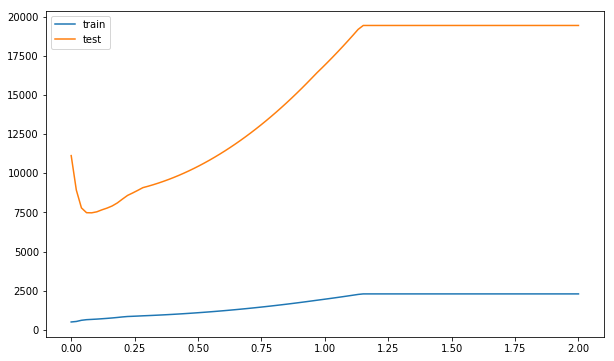

In [56]:
fig =  plt.figure(figsize=(10,6))
plt.plot(lambdas, loss_l1[:, 0], label='train')
plt.plot(lambdas, loss_l1[:, 1], label='test')
plt.legend();

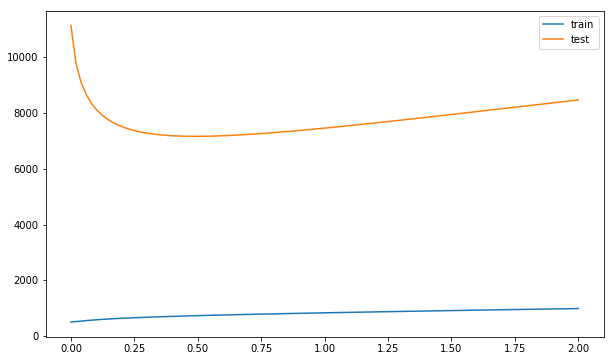

In [57]:
fig =  plt.figure(figsize=(10,6))
plt.plot(lambdas, loss_l2[:, 0], label='train')
plt.plot(lambdas, loss_l2[:, 1], label='test')
plt.legend();

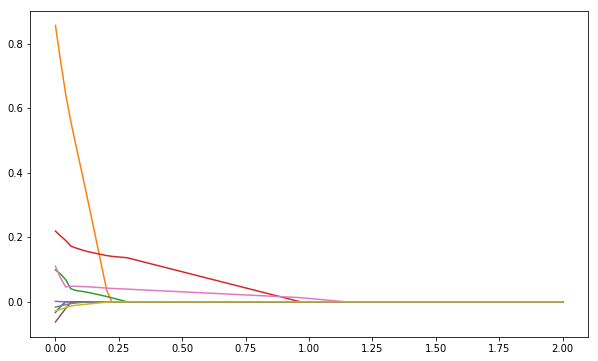

In [43]:
fig =  plt.figure(figsize=(10,6))
plt.plot(lambdas, coef_l1);

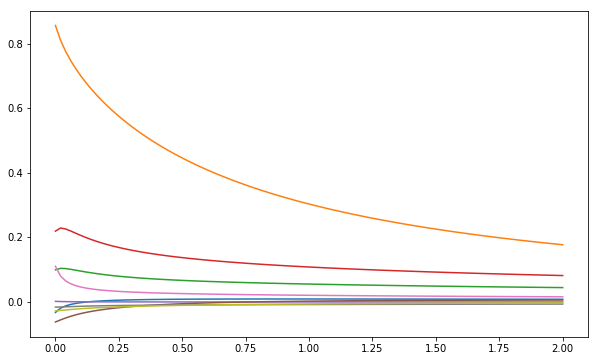

In [44]:
fig =  plt.figure(figsize=(10,6))
plt.plot(lambdas, coef_l2);